In [1]:
from prompt import add_user_message, add_assistant_message, chat
from pprint import pp
messages = []
add_user_message(messages, "What's the weather in San Francisco, California?")
answer = chat(messages)
answer

'I don\'t have the ability to check current weather conditions or forecasts for San Francisco or any other location. To get accurate weather information for San Francisco, California, you could:\n\n1. Check a weather website like Weather.com or AccuWeather\n2. Use a weather app on your phone\n3. Search for "San Francisco weather" on a search engine\n4. Ask a virtual assistant with internet access'

## Tool Use

1.Initial Request: You send Claude a question along with instructions on how to get extra data from external sources

2.Tool Request: Claude analyzes the question and decides it needs additional information, then asks for specific details about what data it needs

3.Data Retrieval: Your server runs code to fetch the requested information from external APIs or databases

4.Final Response: You send the retrieved data back to Claude, which then generates a complete response using both the original question and the fresh data

**for example**:

1.使用者提出問題（例如：「今天天氣如何？」）

2.LLM 判斷需要呼叫特定工具（function），例如「get_weather」來獲取相關資訊

3.伺服器端收到這個呼叫需求，並且用相應工具查詢資料

4.工具結果回傳給 LLM，LLM 根據結果生成回答送回給使用者

## Best Practices for Tool Functions

* **Use descriptive names:** Both your function name and parameter names should clearly indicate their purpose
* **Validate inputs:** Check that required parameters aren't empty or invalid, and raise errors when they are
* **Provide meaningful error messages:** Claude can see error messages and might retry the function call with corrected parameters

In [2]:
import requests
def get_weather(location):
    if not location or location.strip() == "":
        raise ValueError("Location cannot be empty")
    
    url = "https://fakeweatherapi.example.com/current"
    params = {
        "q": location,
        "appid": api_key,
        "units": "metric"
    }
    response = requests.get(url, params=params, timeout=10)
    response.raise_for_status()
    return response.json()


In [3]:
from datetime import datetime
def get_current_datetime(date_format="%Y-%m-%d %H:%M:%S"):
    if not date_format:
        raise ValueError("date_format cannot be empty")
    return datetime.now().strftime(date_format)

get_current_datetime()

'2025-08-11 17:27:59'

## JSON Schema

It has three main parts:

* **name** - A clear, descriptive name for your tool (like "get_weather")
* **description** - What the tool does, when to use it, and what it returns
* **input_schema** - The actual JSON schema describing the function's arguments

"Write a valid JSON schema spec for the purposes of tool calling for this function. Follow the best practices listed in the attached documentation."

def func():
    ...

In [9]:
from datetime import datetime
def get_current_datetime(date_format="%Y-%m-%d %H:%M:%S"):
    if not date_format:
        raise ValueError("date_format cannot be empty")
    return datetime.now().strftime(date_format)
get_current_datetime()

'2025-08-11 19:14:59'

In [1]:
get_current_datetime_schema = {
  "name": "get_current_datetime",
  "description": "Get the current date and time formatted as a string. Returns the current datetime in the specified format.",
  "input_schema": {
    "type": "object",
    "properties": {
      "date_format": {
        "type": "string",
        "description": "The format string for the datetime output using Python strftime format codes. Common formats include '%Y-%m-%d %H:%M:%S' for '2023-12-25 14:30:45', '%Y-%m-%d' for '2023-12-25', '%H:%M:%S' for '14:30:45', '%B %d, %Y' for 'December 25, 2023'. Must not be empty.",
        "default": "%Y-%m-%d %H:%M:%S",
        "examples": [
          "%Y-%m-%d %H:%M:%S",
          "%Y-%m-%d",
          "%H:%M:%S",
          "%B %d, %Y",
          "%A, %B %d, %Y at %I:%M %p"
        ]
      }
    },
    "additionalProperties": False,
    "required": []
  }
}

While not strictly necessary for functionality, this prevents type errors when you use the schema with Claude's API and makes your code more robust.

In [2]:
from anthropic.types import ToolParam
get_current_datetime_schema = ToolParam({
  "name": "get_current_datetime",
  "description": "Get the current date and time formatted as a string. Returns the current datetime in the specified format.",
  "input_schema": {
    "type": "object",
    "properties": {
      "date_format": {
        "type": "string",
        "description": "The format string for the datetime output using Python strftime format codes. Common formats include '%Y-%m-%d %H:%M:%S' for '2023-12-25 14:30:45', '%Y-%m-%d' for '2023-12-25', '%H:%M:%S' for '14:30:45', '%B %d, %Y' for 'December 25, 2023'. Must not be empty.",
        "default": "%Y-%m-%d %H:%M:%S",
        "examples": [
          "%Y-%m-%d %H:%M:%S",
          "%Y-%m-%d",
          "%H:%M:%S",
          "%B %d, %Y",
          "%A, %B %d, %Y at %I:%M %p"
        ]
      }
    },
    "additionalProperties": False,
    "required": []
  }
})
       

## Making Tool-Enabled API Calls

In [ ]:
messages = []
messages.append(
    {
        "role": "user",
        "content": "What is the exact time, formatted as HH:MM:SS?"
    }
)

response = client.messages.create(
    model=model,
    max_tokens=1000,
    messages=messages,
    tools=[get_current_datetime_schema],
)

## Multi-Block Messages

A multi-block message typically contains:

* **Text Block** - Human-readable text explaining what Claude is doing (like "I can help you find out the current time. Let me find that information for you")
* **ToolUse** Block - Instructions for your code about which tool to call and what parameters to use

The ToolUse block includes:

* An ID for tracking the tool call
* The name of the function to call (like "get_current_datetime")
* Input parameters formatted as a dictionary
* The type designation "tool_use"


## The Complete Tool Usage Flow


The tool usage process follows this pattern:

1. Send user message with tool schema to Claude
2. Receive assistant message with text block and tool use block
3. Extract tool information and execute the actual function
4. Send tool result back to Claude along with complete conversation history
5. Receive final response from Claude

In [2]:
from prompt import add_user_message, add_assistant_message, chat
from pprint import pp
messages = []
add_user_message(messages, "What is the exact time, formatted as HH:MM:SS?")
tools = [get_current_datetime_schema]
response = chat(messages, tools=tools)
response

Message(id='msg_01YW4f4LvfomdDyRNYQ8yArF', content=[TextBlock(citations=None, text="I'll get the current time for you in the HH:MM:SS format.", type='text'), ToolUseBlock(id='toolu_01EW2ZFRmpjtXjPgS76RyMP3', input={'date_format': '%H:%M:%S'}, name='get_current_datetime', type='tool_use')], model='claude-3-7-sonnet-20250219', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=588, output_tokens=81, server_tool_use=None, service_tier='standard'))

In [3]:
for block in response.content:
    if block.type == "text":
        print(block.text)
    elif block.type == "tool_use":
        print("Tool call:", block.name)

I'll get the current time for you in the HH:MM:SS format.
Tool call: get_current_datetime


In [12]:
get_current_datetime(**response.content[1].input)

'19:16:01'

## Tool Result Block

The tool result block has several important properties:

* **tool_use_id** - Must match the id of the ToolUse block that this ToolResult corresponds to
* **content** - Output from running your tool, serialized as a string
* **is_error** - True if an error occurred

## Building the Follow-up Request

In [7]:
messages.append({
    "role": "user",
    "content": [{
        "type": "tool_result",
        "tool_use_id": response.content[1].id,
        "content": "19:25:03",
        "is_error": False    
    }]
})
messages

[{'role': 'user', 'content': 'What is the exact time, formatted as HH:MM:SS?'},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01EW2ZFRmpjtXjPgS76RyMP3',
    'content': '19:25:03',
    'is_error': False}]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01EW2ZFRmpjtXjPgS76RyMP3',
    'content': '19:25:03',
    'is_error': False}]}]

The complete message history now contains:

* Original user message
* Assistant message with tool use block
* User message with tool result block

## Making the Final Request

In [2]:
from prompt import add_user_message, add_assistant_message, chat
from pprint import pp
from datetime import datetime
from anthropic.types import ToolParam

def get_current_datetime(date_format="%Y-%m-%d %H:%M:%S"):
    if not date_format:
        raise ValueError("date_format cannot be empty")
    return datetime.now().strftime(date_format)

get_current_datetime_schema = ToolParam({
  "name": "get_current_datetime",
  "description": "Get the current date and time formatted as a string. Returns the current datetime in the specified format.",
  "input_schema": {
    "type": "object",
    "properties": {
      "date_format": {
        "type": "string",
        "description": "The format string for the datetime output using Python strftime format codes. Common formats include '%Y-%m-%d %H:%M:%S' for '2023-12-25 14:30:45', '%Y-%m-%d' for '2023-12-25', '%H:%M:%S' for '14:30:45', '%B %d, %Y' for 'December 25, 2023'. Must not be empty.",
        "default": "%Y-%m-%d %H:%M:%S",
        "examples": [
          "%Y-%m-%d %H:%M:%S",
          "%Y-%m-%d",
          "%H:%M:%S",
          "%B %d, %Y",
          "%A, %B %d, %Y at %I:%M %p"
        ]
      }
    },
    "additionalProperties": False,
    "required": []
  }
})
    
# 1. user 問問題
messages = []
add_user_message(messages, "What is the exact time, formatted as HH:MM:SS?")
tools = [get_current_datetime_schema]

# 2. assistant 回覆（包含 tool_use block）
response = chat(messages, tools=tools)
for block in response.content:
    if block.type == "tool_use":
        tool_use_id = block.id
        tool_input = block.input

# 3. user 回傳 tool_result block
messages.append({
    "role": "assistant",
    "content": response.content  # assistant 回覆的 blocks
})
messages.append({
    "role": "user",
    "content": [{
        "type": "tool_result",
        "tool_use_id": tool_use_id,
        "content": get_current_datetime(**tool_input),
        "is_error": False
    }]
})

# 4. assistant 最終回覆
final_response = chat(messages, tools=tools)
final_response

Message(id='msg_01EuUqJpkA6TtfVQ9aAjRCCE', content=[TextBlock(citations=None, text='The current time is 19:39:23.', type='text')], model='claude-3-7-sonnet-20250219', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=685, output_tokens=15, server_tool_use=None, service_tier='standard'))

In [3]:
final_response.content[0].text

'The current time is 19:39:23.'

## Building a Conversation Loop

In [ ]:
def run_conversation(messages):
    while True:
        response = chat(messages)
        
        add_user_message(messages, response)
        
        # Pseudo code
        if response isn't asking for a tool:
            break
            
        tool_result_blocks = run_tools(response)
        add_user_message(tool_result_blocks)
        
    return messages

## Updating Message Handlers

In [6]:
from anthropic.types import Message

def add_user_message(messages, message):
    user_message = {
        "role": "user",
        "content": message.content if isinstance(message, Message) else message
    }
    messages.append(user_message)

## Updating the Chat Function

In [7]:
def chat(messages, system=None, temperature=1.0, stop_sequences=[], tools=None):
    params = {
        "model": model,
        "max_tokens": 1000,
        "messages": messages,
        "temperature": temperature,
        "stop_sequences": stop_sequences,
    }
    
    if tools:
        params["tools"] = tools
        
    if system:
        params["system"] = system
        
    message = client.messages.create(**params)
    return message

## Extracting Text from Messages


In [ ]:
def text_from_message(message):
    return "\n".join(
        [block.text for block in message.content if block.type == "text"]
    )

## Detecting Tool Requests

In [ ]:
if response.stop_reason != "tool_use":
    break # Claude is done, no more tools needed

## The Conversation Loop

In [ ]:
def run_conversation(messages):
    while True:
        response = chat(messages, tools=[get_current_datetime_schema])
        add_assistant_message(messages, response)
        print(text_from_message(response))
        if response.stop_reason != "tool_use":
            break
        tool_result = run_tools(response)
        add_user_message(messages, tool_result)
    return messages

## Handling Multiple Tool Calls

In [ ]:
def run_tools(response):
    tool_requests = [
        block for block in response.content if block.type == "tool_use"
    ]
    tool_result_blocks = []
    for tool_request in tool_requests:
        # Process each tool request

## Tool Result Blocks

In [ ]:
import json
def run_tools(response):
    tool_requests = [
        block for block in response.content if block.type == "tool_use"
    ]
    tool_result_blocks = []
    for tool_request in tool_requests:
        if tool_request.name == "get_current_datetime":
            tool_output = get_current_datetime(**tool_request.input)
            tool_result_block = {
                "type": "tool_result",
                "tool_use_id": tool_request.id,
                "content": json.dumps(tool_output)
                "is_error": False
            }
        tool_result_blocks.append(tool_result_block)


    return tool_result_blocks

## Error Handling

In [ ]:
try:
    tool_output = run_tool(tool_request_name, **tool_request_input)
    tool_result_block = {
                "type": "tool_result",
                "tool_use_id": tool_request.id,
                "content": json.dumps(tool_output),
                "is_error": False
            }

except Exception as e:
    tool_result_block = {
                "type": "tool_result",
                "tool_use_id": tool_request.id,
                "content": f"Error: {e}",
                "is_error": True
            }


## Scalable Tool Routing


In [ ]:
def run_tool(tool_name, tool_input):
    if tool_name == "get_current_datetime":
        return get_current_datetime(**tool_input)
    elif tool_name == "another_tool":
        return another_tool(**tool_input)
    # Add more tools as needed

## Complete Workflow

* Send user message to Claude with available tools
* Claude responds with text and/or tool requests
* Execute all requested tools and create result blocks
* Send tool results back as a user message
* Repeat until Claude provides a final answer

In [9]:
from prompt import add_user_message, add_assistant_message, chat
from pprint import pp
from datetime import datetime
from anthropic.types import ToolParam
import json

def get_current_datetime(date_format="%Y-%m-%d %H:%M:%S"):
    if not date_format:
        raise ValueError("date_format cannot be empty")
    return datetime.now().strftime(date_format)

get_current_datetime_schema = ToolParam({
    "name": "get_current_datetime",
    "description": "Get the current date and time formatted as a string. Returns the current datetime in the specified format.",
    "input_schema": {
        "type": "object",
        "properties": {
        "date_format": {
            "type": "string",
            "description": "The format string for the datetime output using Python strftime format codes. Common formats include '%Y-%m-%d %H:%M:%S' for '2023-12-25 14:30:45', '%Y-%m-%d' for '2023-12-25', '%H:%M:%S' for '14:30:45', '%B %d, %Y' for 'December 25, 2023'. Must not be empty.",
            "default": "%Y-%m-%d %H:%M:%S",
            "examples": [
            "%Y-%m-%d %H:%M:%S",
            "%Y-%m-%d",
            "%H:%M:%S",
            "%B %d, %Y",
            "%A, %B %d, %Y at %I:%M %p"
            ]
        }
        },
        "additionalProperties": False,
        "required": []
    }
})

def text_from_message(message):
    return "\n".join(
        [block.text for block in message.content if block.type == "text"]
    )

def run_tool(tool_name, tool_input):
    if tool_name == "get_current_datetime":
        return get_current_datetime(**tool_input)

def run_tools(message):
    tool_requests = [
        block for block in message.content if block.type == "tool_use"
    ]
    tool_result_blocks = []

    for tool_request in tool_requests:
        try:
            tool_output = run_tool(tool_request.name, tool_request.input)
            tool_result_block = {
                "type": "tool_result",
                "tool_use_id": tool_request.id,
                "content": json.dumps(tool_output),
                "is_error": False,
            }
        except Exception as e:
            tool_result_block = {
                "type": "tool_result",
                "tool_use_id": tool_request.id,
                "content": f"Error: {e}",
                "is_error": True,
            }

        tool_result_blocks.append(tool_result_block)

    return tool_result_blocks

def run_conversation(messages):
    while True:
        response = chat(messages, tools=[get_current_datetime_schema])

        add_assistant_message(messages, response)
        print(text_from_message(response))

        if response.stop_reason != "tool_use":
            break

        tool_results = run_tools(response)
        add_user_message(messages, tool_results)

    return messages

messages = []
add_user_message(
    messages,
    "What is the current time in HH:MM format? Also, what is the current time in HH:MM:SS format?",
)
run_conversation(messages)

I'll get the current time for you in both formats you requested.
The current time in HH:MM format is 10:36.
The current time in HH:MM:SS format is 10:36:05.


[{'role': 'user',
  'content': 'What is the current time in HH:MM format? Also, what is the current time in HH:MM:SS format?'},
 {'role': 'assistant',
  'content': [TextBlock(citations=None, text="I'll get the current time for you in both formats you requested.", type='text'),
   ToolUseBlock(id='toolu_016XmwD72UBuck9pakb4arAc', input={'date_format': '%H:%M'}, name='get_current_datetime', type='tool_use')]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_016XmwD72UBuck9pakb4arAc',
    'content': '"10:36"',
    'is_error': False}]},
 {'role': 'assistant',
  'content': [TextBlock(citations=None, text='The current time in HH:MM format is 10:36.', type='text'),
   ToolUseBlock(id='toolu_01QeCwCwRghcizxczGjQYC3P', input={'date_format': '%H:%M:%S'}, name='get_current_datetime', type='tool_use')]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01QeCwCwRghcizxczGjQYC3P',
    'content': '"10:36:05"',
    'is_error': False}]}

## The Simple Pattern for Adding Tools

1. Create the tool function implementation
2. Define the tool schema
3. Add the schema to the tools list in run_conversation
4. Add a case for the tool in run_tool

In [11]:
from prompt import add_user_message, add_assistant_message, chat
from pprint import pp
from datetime import datetime, timedelta
from anthropic.types import ToolParam
import json

def get_current_datetime(date_format="%Y-%m-%d %H:%M:%S"):
    if not date_format:
        raise ValueError("date_format cannot be empty")
    return datetime.now().strftime(date_format)

get_current_datetime_schema = ToolParam({
    "name": "get_current_datetime",
    "description": "Get the current date and time formatted as a string. Returns the current datetime in the specified format.",
    "input_schema": {
        "type": "object",
        "properties": {
        "date_format": {
            "type": "string",
            "description": "The format string for the datetime output using Python strftime format codes. Common formats include '%Y-%m-%d %H:%M:%S' for '2023-12-25 14:30:45', '%Y-%m-%d' for '2023-12-25', '%H:%M:%S' for '14:30:45', '%B %d, %Y' for 'December 25, 2023'. Must not be empty.",
            "default": "%Y-%m-%d %H:%M:%S",
            "examples": [
            "%Y-%m-%d %H:%M:%S",
            "%Y-%m-%d",
            "%H:%M:%S",
            "%B %d, %Y",
            "%A, %B %d, %Y at %I:%M %p"
            ]
        }
        },
        "additionalProperties": False,
        "required": []
    }
})

def add_duration_to_datetime(
    datetime_str, duration=0, unit="days", input_format="%Y-%m-%d"
):
    date = datetime.strptime(datetime_str, input_format)

    if unit == "seconds":
        new_date = date + timedelta(seconds=duration)
    elif unit == "minutes":
        new_date = date + timedelta(minutes=duration)
    elif unit == "hours":
        new_date = date + timedelta(hours=duration)
    elif unit == "days":
        new_date = date + timedelta(days=duration)
    elif unit == "weeks":
        new_date = date + timedelta(weeks=duration)
    elif unit == "months":
        month = date.month + duration
        year = date.year + month // 12
        month = month % 12
        if month == 0:
            month = 12
            year -= 1
        day = min(
            date.day,
            [
                31,
                29
                if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
                else 28,
                31,
                30,
                31,
                30,
                31,
                31,
                30,
                31,
                30,
                31,
            ][month - 1],
        )
        new_date = date.replace(year=year, month=month, day=day)
    elif unit == "years":
        new_date = date.replace(year=date.year + duration)
    else:
        raise ValueError(f"Unsupported time unit: {unit}")

    return new_date.strftime("%A, %B %d, %Y %I:%M:%S %p")

add_duration_to_datetime_schema = {
    "name": "add_duration_to_datetime",
    "description": "Adds a specified duration to a datetime string and returns the resulting datetime in a detailed format. This tool converts an input datetime string to a Python datetime object, adds the specified duration in the requested unit, and returns a formatted string of the resulting datetime. It handles various time units including seconds, minutes, hours, days, weeks, months, and years, with special handling for month and year calculations to account for varying month lengths and leap years. The output is always returned in a detailed format that includes the day of the week, month name, day, year, and time with AM/PM indicator (e.g., 'Thursday, April 03, 2025 10:30:00 AM').",
    "input_schema": {
        "type": "object",
        "properties": {
            "datetime_str": {
                "type": "string",
                "description": "The input datetime string to which the duration will be added. This should be formatted according to the input_format parameter.",
            },
            "duration": {
                "type": "number",
                "description": "The amount of time to add to the datetime. Can be positive (for future dates) or negative (for past dates). Defaults to 0.",
            },
            "unit": {
                "type": "string",
                "description": "The unit of time for the duration. Must be one of: 'seconds', 'minutes', 'hours', 'days', 'weeks', 'months', or 'years'. Defaults to 'days'.",
            },
            "input_format": {
                "type": "string",
                "description": "The format string for parsing the input datetime_str, using Python's strptime format codes. For example, '%Y-%m-%d' for ISO format dates like '2025-04-03'. Defaults to '%Y-%m-%d'.",
            },
        },
        "required": ["datetime_str"],
    },
}

def set_reminder(content, timestamp):
    print(
        f"----\nSetting the following reminder for {timestamp}:\n{content}\n----"
    )

set_reminder_schema = {
    "name": "set_reminder",
    "description": "Creates a timed reminder that will notify the user at the specified time with the provided content. This tool schedules a notification to be delivered to the user at the exact timestamp provided. It should be used when a user wants to be reminded about something specific at a future point in time. The reminder system will store the content and timestamp, then trigger a notification through the user's preferred notification channels (mobile alerts, email, etc.) when the specified time arrives. Reminders are persisted even if the application is closed or the device is restarted. Users can rely on this function for important time-sensitive notifications such as meetings, tasks, medication schedules, or any other time-bound activities.",
    "input_schema": {
        "type": "object",
        "properties": {
            "content": {
                "type": "string",
                "description": "The message text that will be displayed in the reminder notification. This should contain the specific information the user wants to be reminded about, such as 'Take medication', 'Join video call with team', or 'Pay utility bills'.",
            },
            "timestamp": {
                "type": "string",
                "description": "The exact date and time when the reminder should be triggered, formatted as an ISO 8601 timestamp (YYYY-MM-DDTHH:MM:SS) or a Unix timestamp. The system handles all timezone processing internally, ensuring reminders are triggered at the correct time regardless of where the user is located. Users can simply specify the desired time without worrying about timezone configurations.",
            },
        },
        "required": ["content", "timestamp"],
    },
}

def text_from_message(message):
    return "\n".join(
        [block.text for block in message.content if block.type == "text"]
    )

def run_tool(tool_name, tool_input):
    if tool_name == "get_current_datetime":
        return get_current_datetime(**tool_input)
    elif tool_name == "add_duration_to_datetime":
        return add_duration_to_datetime(**tool_input)
    elif tool_name == "set_reminder":
        return set_reminder(**tool_input)

def run_tools(message):
    tool_requests = [
        block for block in message.content if block.type == "tool_use"
    ]
    tool_result_blocks = []

    for tool_request in tool_requests:
        try:
            tool_output = run_tool(tool_request.name, tool_request.input)
            tool_result_block = {
                "type": "tool_result",
                "tool_use_id": tool_request.id,
                "content": json.dumps(tool_output),
                "is_error": False,
            }
        except Exception as e:
            tool_result_block = {
                "type": "tool_result",
                "tool_use_id": tool_request.id,
                "content": f"Error: {e}",
                "is_error": True,
            }

        tool_result_blocks.append(tool_result_block)

    return tool_result_blocks

def run_conversation(messages):
    while True:
        response = chat(messages, tools=[get_current_datetime_schema, add_duration_to_datetime_schema, set_reminder_schema])

        add_assistant_message(messages, response)
        print(text_from_message(response))

        if response.stop_reason != "tool_use":
            break

        tool_results = run_tools(response)
        add_user_message(messages, tool_results)

    return messages

messages = []
add_user_message(
    messages,
    "Set a reminder for my doctor's appointmet. It's 177 days after Jan 1st, 2050.",
)
run_conversation(messages)

I'll help you set a reminder for your doctor's appointment. First, I need to calculate the exact date that is 177 days after January 1st, 2050.
Now I'll set a reminder for your doctor's appointment on June 27, 2050:
----
Setting the following reminder for 2050-06-27T00:00:00:
Doctor's appointment
----
I've set a reminder for your doctor's appointment on Monday, June 27, 2050. You'll receive a notification on that day to remind you of your appointment.


[{'role': 'user',
  'content': "Set a reminder for my doctor's appointmet. It's 177 days after Jan 1st, 2050."},
 {'role': 'assistant',
  'content': [TextBlock(citations=None, text="I'll help you set a reminder for your doctor's appointment. First, I need to calculate the exact date that is 177 days after January 1st, 2050.", type='text'),
   ToolUseBlock(id='toolu_01HcUQw2VqxcKg24xWkBbyr9', input={'datetime_str': '2050-01-01', 'duration': 177, 'unit': 'days', 'input_format': '%Y-%m-%d'}, name='add_duration_to_datetime', type='tool_use')]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01HcUQw2VqxcKg24xWkBbyr9',
    'content': '"Monday, June 27, 2050 12:00:00 AM"',
    'is_error': False}]},
 {'role': 'assistant',
  'content': [TextBlock(citations=None, text="Now I'll set a reminder for your doctor's appointment on June 27, 2050:", type='text'),
   ToolUseBlock(id='toolu_013ngkUk9V5Tcjc6AHJQmW4j', input={'content': "Doctor's appointment", 'timestamp':

## How the Batch Tool Works

The batch tool receives a list of invocations, where each invocation specifies:

* The name of the tool to call
* The arguments to pass to that tool

## Implementing the Batch Tool Schema


In [12]:
from anthropic.types import ToolParam

batch_tool_schema = ToolParam({
    "name": "batch_tool",
    "description": "Invoke multiple other tool calls simultaneously",
    "input_schema": {
        "type": "object",
        "properties": {
            "invocations": {
                "type": "array",
                "description": "The tool calls to invoke",
                "items": {
                    "type": "object",
                    "properties": {
                        "name": {
                            "type": "string",
                            "description": "The name of the tool to invoke"
                        },
                        "arguments": {
                            "type": "object",
                            "description": "The arguments to pass to the tool"
                        }
                    }
                }
            }
        }
    }
})


## Implementing the Batch Function

In [13]:
import json
def run_batch(invocations=[]):
    batch_output = []
    for invocation in invocations:
        name = invocation["name"]
        args = json.loads(invocation["arguments"])
        
        tool_output = run_tool(name, args)

        batch_output.append({
            "tool_name": name,
            "output": tool_output
        })

    return batch_output



This function:

1. Iterates through each invocation in the list
2. Extracts the tool name and arguments
3. Calls the appropriate tool using your existing run_tool function
4. Collects all the results into a batch output list


In [14]:
def run_tool(tool_name, tool_input):
    if tool_name == "get_current_datetime":
        return get_current_datetime(**tool_input)
    elif tool_name == "add_duration_to_datetime":
        return add_duration_to_datetime(**tool_input)
    elif tool_name == "set_reminder":
        return set_reminder(**tool_input)
    elif tool_name == "batch_tool":
        return run_batch(**tool_input)

In [15]:
from prompt import add_user_message, add_assistant_message, chat
from pprint import pp
from datetime import datetime, timedelta
from anthropic.types import ToolParam
import json

def get_current_datetime(date_format="%Y-%m-%d %H:%M:%S"):
    if not date_format:
        raise ValueError("date_format cannot be empty")
    return datetime.now().strftime(date_format)

get_current_datetime_schema = ToolParam({
    "name": "get_current_datetime",
    "description": "Get the current date and time formatted as a string. Returns the current datetime in the specified format.",
    "input_schema": {
        "type": "object",
        "properties": {
        "date_format": {
            "type": "string",
            "description": "The format string for the datetime output using Python strftime format codes. Common formats include '%Y-%m-%d %H:%M:%S' for '2023-12-25 14:30:45', '%Y-%m-%d' for '2023-12-25', '%H:%M:%S' for '14:30:45', '%B %d, %Y' for 'December 25, 2023'. Must not be empty.",
            "default": "%Y-%m-%d %H:%M:%S",
            "examples": [
            "%Y-%m-%d %H:%M:%S",
            "%Y-%m-%d",
            "%H:%M:%S",
            "%B %d, %Y",
            "%A, %B %d, %Y at %I:%M %p"
            ]
        }
        },
        "additionalProperties": False,
        "required": []
    }
})

def add_duration_to_datetime(
    datetime_str, duration=0, unit="days", input_format="%Y-%m-%d"
):
    date = datetime.strptime(datetime_str, input_format)

    if unit == "seconds":
        new_date = date + timedelta(seconds=duration)
    elif unit == "minutes":
        new_date = date + timedelta(minutes=duration)
    elif unit == "hours":
        new_date = date + timedelta(hours=duration)
    elif unit == "days":
        new_date = date + timedelta(days=duration)
    elif unit == "weeks":
        new_date = date + timedelta(weeks=duration)
    elif unit == "months":
        month = date.month + duration
        year = date.year + month // 12
        month = month % 12
        if month == 0:
            month = 12
            year -= 1
        day = min(
            date.day,
            [
                31,
                29
                if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
                else 28,
                31,
                30,
                31,
                30,
                31,
                31,
                30,
                31,
                30,
                31,
            ][month - 1],
        )
        new_date = date.replace(year=year, month=month, day=day)
    elif unit == "years":
        new_date = date.replace(year=date.year + duration)
    else:
        raise ValueError(f"Unsupported time unit: {unit}")

    return new_date.strftime("%A, %B %d, %Y %I:%M:%S %p")

add_duration_to_datetime_schema = {
    "name": "add_duration_to_datetime",
    "description": "Adds a specified duration to a datetime string and returns the resulting datetime in a detailed format. This tool converts an input datetime string to a Python datetime object, adds the specified duration in the requested unit, and returns a formatted string of the resulting datetime. It handles various time units including seconds, minutes, hours, days, weeks, months, and years, with special handling for month and year calculations to account for varying month lengths and leap years. The output is always returned in a detailed format that includes the day of the week, month name, day, year, and time with AM/PM indicator (e.g., 'Thursday, April 03, 2025 10:30:00 AM').",
    "input_schema": {
        "type": "object",
        "properties": {
            "datetime_str": {
                "type": "string",
                "description": "The input datetime string to which the duration will be added. This should be formatted according to the input_format parameter.",
            },
            "duration": {
                "type": "number",
                "description": "The amount of time to add to the datetime. Can be positive (for future dates) or negative (for past dates). Defaults to 0.",
            },
            "unit": {
                "type": "string",
                "description": "The unit of time for the duration. Must be one of: 'seconds', 'minutes', 'hours', 'days', 'weeks', 'months', or 'years'. Defaults to 'days'.",
            },
            "input_format": {
                "type": "string",
                "description": "The format string for parsing the input datetime_str, using Python's strptime format codes. For example, '%Y-%m-%d' for ISO format dates like '2025-04-03'. Defaults to '%Y-%m-%d'.",
            },
        },
        "required": ["datetime_str"],
    },
}

def set_reminder(content, timestamp):
    print(
        f"----\nSetting the following reminder for {timestamp}:\n{content}\n----"
    )

set_reminder_schema = {
    "name": "set_reminder",
    "description": "Creates a timed reminder that will notify the user at the specified time with the provided content. This tool schedules a notification to be delivered to the user at the exact timestamp provided. It should be used when a user wants to be reminded about something specific at a future point in time. The reminder system will store the content and timestamp, then trigger a notification through the user's preferred notification channels (mobile alerts, email, etc.) when the specified time arrives. Reminders are persisted even if the application is closed or the device is restarted. Users can rely on this function for important time-sensitive notifications such as meetings, tasks, medication schedules, or any other time-bound activities.",
    "input_schema": {
        "type": "object",
        "properties": {
            "content": {
                "type": "string",
                "description": "The message text that will be displayed in the reminder notification. This should contain the specific information the user wants to be reminded about, such as 'Take medication', 'Join video call with team', or 'Pay utility bills'.",
            },
            "timestamp": {
                "type": "string",
                "description": "The exact date and time when the reminder should be triggered, formatted as an ISO 8601 timestamp (YYYY-MM-DDTHH:MM:SS) or a Unix timestamp. The system handles all timezone processing internally, ensuring reminders are triggered at the correct time regardless of where the user is located. Users can simply specify the desired time without worrying about timezone configurations.",
            },
        },
        "required": ["content", "timestamp"],
    },
}

def run_batch(invocations=[]):
    batch_output = []
    for invocation in invocations:
        name = invocation["name"]
        args = json.loads(invocation["arguments"])
        
        tool_output = run_tool(name, args)

        batch_output.append({
            "tool_name": name,
            "output": tool_output
        })

    return batch_output

batch_tool_schema = ToolParam({
    "name": "batch_tool",
    "description": "Invoke multiple other tool calls simultaneously",
    "input_schema": {
        "type": "object",
        "properties": {
            "invocations": {
                "type": "array",
                "description": "The tool calls to invoke",
                "items": {
                    "type": "object",
                    "properties": {
                        "name": {
                            "type": "string",
                            "description": "The name of the tool to invoke"
                        },
                        "arguments": {
                            "type": "object",
                            "description": "The arguments to pass to the tool"
                        }
                    }
                }
            }
        }
    }
})


def text_from_message(message):
    return "\n".join(
        [block.text for block in message.content if block.type == "text"]
    )

def run_tool(tool_name, tool_input):
    if tool_name == "get_current_datetime":
        return get_current_datetime(**tool_input)
    elif tool_name == "add_duration_to_datetime":
        return add_duration_to_datetime(**tool_input)
    elif tool_name == "set_reminder":
        return set_reminder(**tool_input)
    elif tool_name == "batch_tool":
        return run_batch(**tool_input)  

def run_tools(message):
    tool_requests = [
        block for block in message.content if block.type == "tool_use"
    ]
    tool_result_blocks = []

    for tool_request in tool_requests:
        try:
            tool_output = run_tool(tool_request.name, tool_request.input)
            tool_result_block = {
                "type": "tool_result",
                "tool_use_id": tool_request.id,
                "content": json.dumps(tool_output),
                "is_error": False,
            }
        except Exception as e:
            tool_result_block = {
                "type": "tool_result",
                "tool_use_id": tool_request.id,
                "content": f"Error: {e}",
                "is_error": True,
            }

        tool_result_blocks.append(tool_result_block)

    return tool_result_blocks

def run_conversation(messages):
    while True:
        response = chat(messages, tools=[get_current_datetime_schema, add_duration_to_datetime_schema, set_reminder_schema, batch_tool_schema])

        add_assistant_message(messages, response)
        print(text_from_message(response))

        if response.stop_reason != "tool_use":
            break

        tool_results = run_tools(response)
        add_user_message(messages, tool_results)

    return messages

messages = []
add_user_message(
    messages,
    """
        Set two reminders for Jan 1, 2025 at 8 AM:
            * I have a doctors appointment
            * Taxes are due          
    """
)
run_conversation(messages)

I'll set those two reminders for you for January 1, 2025 at 8:00 AM.

First, I need to format the date and time properly for the reminder system:
I apologize for the error. Let me set those reminders individually:
----
Setting the following reminder for 2025-01-01T08:00:00:
I have a doctors appointment
----

----
Setting the following reminder for 2025-01-01T08:00:00:
Taxes are due
----
Great! I've successfully set both reminders for January 1, 2025 at 8:00 AM:

1. "I have a doctors appointment"
2. "Taxes are due"

Both reminders will notify you at the same time on New Year's Day 2025.


[{'role': 'user',
  'content': '\n        Set two reminders for Jan 1, 2025 at 8 AM:\n            * I have a doctors appointment\n            * Taxes are due          \n    '},
 {'role': 'assistant',
  'content': [TextBlock(citations=None, text="I'll set those two reminders for you for January 1, 2025 at 8:00 AM.\n\nFirst, I need to format the date and time properly for the reminder system:", type='text'),
   ToolUseBlock(id='toolu_01GTDV85BkVo5NzDb4nt2aDZ', input={'invocations': [{'name': 'set_reminder', 'arguments': {'content': 'I have a doctors appointment', 'timestamp': '2025-01-01T08:00:00'}}, {'name': 'set_reminder', 'arguments': {'content': 'Taxes are due', 'timestamp': '2025-01-01T08:00:00'}}]}, name='batch_tool', type='tool_use')]},
 {'role': 'user',
  'content': [{'type': 'tool_result',
    'tool_use_id': 'toolu_01GTDV85BkVo5NzDb4nt2aDZ',
    'content': 'Error: the JSON object must be str, bytes or bytearray, not dict',
    'is_error': True}]},
 {'role': 'assistant',
  'conte

## Controlling Tool Use

* {"type": "auto"} - Model decides if it needs to use a tool (default)
* {"type": "any"} - Model must use a tool, but can choose which one
* {"type": "tool", "name": "TOOL_NAME"} - Model must use the specified tool

## Implementation Example

In [11]:
from prompt import add_user_message, add_assistant_message, chat
from pprint import pp
import json

In [12]:
article_summary_schema = {
    "name": "article_summary",
    "description": "Creates a summary of an article with its key insights. Use this tool when you need to generate a structured summary of an article, research paper, or any textual content. The tool requires the article's title, author name, and a list of the most important insights or takeaways from the content. Each insight should be a concise statement capturing a significant point from the article.",
    "input_schema": {
        "type": "object",
        "properties": {
            "title": {
                "type": "string",
                "description": "The title of the article being summarized.",
            },
            "author": {
                "type": "string",
                "description": "The name of the author who wrote the article.",
            },
            "key_insights": {
                "type": "array",
                "items": {"type": "string"},
                "description": "A list of the most important takeaways or insights from the article. Each insight should be a complete, concise statement.",
            },
        },
        "required": ["title", "author", "key_insights"],
    },
}

In [14]:
def text_from_message(message):
    return "\n".join(
        [block.text for block in message.content if block.type == "text"]
    )

messages = []
add_user_message(
    messages,
    """
    Write a one-paragraph scholarly article about computer science. 
    Include a title and author name.
    """
)
response = chat(messages)
text_from_message(response)

"# The Evolution of Computer Science: From Theoretical Foundations to Practical Applications\n\nBy Dr. Eleanor J. Thornton\n\nComputer science, a discipline that emerged in the mid-20th century at the intersection of mathematics, electrical engineering, and logic, has undergone remarkable transformation to become one of the most influential fields in modern society. What began as theoretical explorations of computation through Turing machines and lambda calculus has evolved into a multifaceted discipline encompassing algorithms, data structures, artificial intelligence, machine learning, computer architecture, networking, and human-computer interaction. The exponential growth in computational power, as predicted by Moore's Law, has enabled increasingly complex applications while simultaneously presenting new challenges in areas such as security, privacy, and ethical computing. Contemporary computer science research continues to push boundaries in quantum computing, neuromorphic systems

In [15]:
messages = []

add_user_message(messages, text_from_message(response))
response = chat(
    messages,
    tools=[article_summary_schema],
    tool_choice={"type": "tool", "name": "article_summary"},
)
response.content[0].input

{'title': 'The Evolution of Computer Science: From Theoretical Foundations to Practical Applications',
 'author': 'Dr. Eleanor J. Thornton',
 'key_insights': ['Computer science emerged in the mid-20th century at the intersection of mathematics, electrical engineering, and logic, beginning with theoretical concepts like Turing machines and lambda calculus.',
  'The field has evolved from purely theoretical foundations into a multifaceted discipline encompassing algorithms, data structures, AI, machine learning, computer architecture, networking, and human-computer interaction.',
  "Moore's Law and exponential growth in computational power have enabled increasingly complex applications while creating new challenges in security, privacy, and ethical computing.",
  'Contemporary computer science research is advancing frontiers in quantum computing, neuromorphic systems, and distributed architectures.',
  'The field demonstrates remarkable capacity to both drive technological innovation and

## When to Use Each Approach

Choose prompt-based structured output when you need something quick and simple. Use tools when you need guaranteed reliability and can handle the extra setup complexity. Both techniques are valuable depending on your specific use case and requirements.

## Basic Tool Streaming

Each InputJsonEvent contains two key properties:

* **partial_json** - A chunk of JSON representing part of the tool arguments
* **snapshot** - The cumulative JSON built up from all chunks received so far

In [ ]:
for chunk in stream:
    if chunk.type == "input_json":
        # Process the partial JSON chunk
        print(chunk.partial_json)
        # Or use the complete snapshot so far
        current_args = chunk.snapshot

Fine-grained tool calling does one main thing: it disables JSON validation on the API side. This means:

* You get chunks as soon as Claude generates them
* No buffering delays between top-level keys
* More traditional streaming behavior
* Critical: JSON validation is disabled - your code must handle invalid JSON
Enable it by adding fine_grained=True to your API call:



In [ ]:
run_conversation(
    messages, 
    tools=[save_article_schema], 
    fine_grained=True
)

## Handling Invalid JSON


In [ ]:
try:
    parsed_args = json.loads(chunk.snapshot)
except json.JSONDecodeError:
    # Handle invalid JSON appropriately
    print("Received invalid JSON, continuing...")

## When to Use Fine-Grained Tool Calling

Consider enabling fine-grained tool calling when:

* You need to show users real-time progress on tool argument generation
* You want to start processing partial tool results as quickly as possible
* The buffering delays negatively impact your user experience
* You're comfortable implementing robust JSON error handling

In [1]:
from prompt_stream import add_user_message, add_assistant_message, chat_stream
from anthropic.types import ToolParam
from pprint import pp
import json

save_article_schema = ToolParam(
    {
        "name": "save_article",
        "description": "Saves a scholarly journal article",
        "input_schema": {
            "type": "object",
            "properties": {
                "abstract": {
                    "type": "string",
                    "description": "Abstract of the article. One short sentence max",
                },
                "meta": {
                    "type": "object",
                    "properties": {
                        "word_count": {
                            "type": "integer",
                            "description": "Word count",
                        },
                        "review": {
                            "type": "string",
                            "description": "Eight sentence review of the paper",
                        },
                    },
                    "required": ["word_count", "review"],
                },
            },
            "required": ["abstract", "meta"],
        },
    }
)
save_short_article_schema = ToolParam(
    {
        "name": "save_article",
        "description": "Saves a scholarly journal article",
        "input_schema": {
            "type": "object",
            "properties": {
                "abstract": {
                    "type": "string",
                    "description": "Abstract of the article. One short sentence max",
                },
                "meta": {
                    "type": "object",
                    "properties": {
                        "word_count": {
                            "type": "integer",
                            "description": "Word count",
                        },
                        "review": {
                            "type": "string",
                            "description": "Review of paper. One short sentence max",
                        },
                    },
                    "required": ["word_count", "review"],
                },
            },
            "required": ["abstract", "meta"],
        },
    }
)


def save_article(**kwargs):
    return "Article saved!"

def run_tool(tool_name, tool_input):
    if tool_name == "save_article":
        return save_article(**tool_input)


def run_tools(message):
    tool_requests = [
        block for block in message.content if block.type == "tool_use"
    ]
    tool_result_blocks = []

    for tool_request in tool_requests:
        try:
            tool_output = run_tool(tool_request.name, tool_request.input)
            tool_result_block = {
                "type": "tool_result",
                "tool_use_id": tool_request.id,
                "content": json.dumps(tool_output),
                "is_error": False,
            }
        except Exception as e:
            tool_result_block = {
                "type": "tool_result",
                "tool_use_id": tool_request.id,
                "content": f"Error: {e}",
                "is_error": True,
            }

        tool_result_blocks.append(tool_result_block)

    return tool_result_blocks

# Run conversation
def run_conversation(messages, tools=[], tool_choice=None, fine_grained=False):
    while True:
        with chat_stream(
            messages,
            tools=tools,
            betas=["fine-grained-tool-streaming-2025-05-14"]
            if fine_grained
            else [],
            tool_choice=tool_choice,
        ) as stream:
            for chunk in stream:
                if chunk.type == "text":
                    print(chunk.text, end="")

                if chunk.type == "content_block_start":
                    if chunk.content_block.type == "tool_use":
                        print(f'\n>>> Tool Call: "{chunk.content_block.name}"')

                if chunk.type == "input_json" and chunk.partial_json:
                    print(chunk.partial_json, end="")

                if chunk.type == "content_block_stop":
                    print("\n")

            response = stream.get_final_message()

        add_assistant_message(messages, response)

        if response.stop_reason != "tool_use":
            break

        tool_results = run_tools(response)
        add_user_message(messages, tool_results)

        if tool_choice:
            break

    return messages

In [2]:
messages = []

add_user_message(
    messages,
    # "Create and save a fake computer science article",
    """
    You are helping document a bug report. Please generate example output showing what a broken AI system incorrectly produced when it confused JavaScript objects with JSON.
    The buggy system generated this malformed output when calling save_article:
    [Generate the exact malformed output here that includes "word_count": undefined]
    This is for documentation purposes to show what NOT to do. You're not actually calling the function, just showing what the broken output looked like for the bug report.
    """,
)

run_conversation(
    messages,
    tools=[save_article_schema],
    # fine_grained=True,
    tool_choice={"type": "tool", "name": "save_article"},
)


>>> Tool Call: "save_article"
{"abstract": "Example of malformed output for bug documentation", "meta": "{\"word_count\": undefined, \"review\": \"This paper demonstrates a common error when confusing JavaScript objects with JSON. JavaScript allows undefined as a value, but JSON does not. This causes parsing errors when the output is processed. Systems must properly serialize all values to valid JSON. The undefined keyword is not valid in JSON and must be converted to null or omitted. This example shows how the bug manifests in API calls. Debugging such issues requires careful inspection of the serialization process.\"}"}



[{'role': 'user',
  'content': [{'type': 'text',
    'text': '\n    You are helping document a bug report. Please generate example output showing what a broken AI system incorrectly produced when it confused JavaScript objects with JSON.\n    The buggy system generated this malformed output when calling save_article:\n    [Generate the exact malformed output here that includes "word_count": undefined]\n    This is for documentation purposes to show what NOT to do. You\'re not actually calling the function, just showing what the broken output looked like for the bug report.\n    '}]},
 {'role': 'assistant',
  'content': [{'type': 'tool_use',
    'id': 'toolu_019Xo8wnTa5ejahwsHzLRfEq',
    'name': 'save_article',
    'input': {'abstract': 'Example of malformed output for bug documentation',
     'meta': '{"word_count": undefined, "review": "This paper demonstrates a common error when confusing JavaScript objects with JSON. JavaScript allows undefined as a value, but JSON does not. This c

## The Text Edit Tool

**Important Note: Tool version strings can for all model versions can be found here:** https://docs.anthropic.com/en/docs/agents-and-tools/tool-use/text-editor-tool

005_text_editor_tool.ipynb

## What the Text Editor Tool Can Do

The text editor tool provides Claude with a comprehensive set of file manipulation capabilities:

* View file or directory contents
* View specific ranges of lines in a file
* Replace text in a file
* Create new files
* Insert text at specific lines in a file
* Undo recent edits to files

## Why Use the Text Editor Tool?

You might wonder why this tool exists when modern code editors already have AI assistants built in. The text editor tool becomes valuable in scenarios where:

* You're building applications that need to programmatically edit files
* You're working in environments without access to full-featured code editors
* You want to integrate file editing capabilities directly into your Claude-powered applications

## The Web Search Tool

Important note: Your organization must enable the Web Search tool in the settings console before using it. You can find this setting here: https://console.anthropic.com/settings/privacy

006_web_search_complete.ipynb

In [3]:
web_search_schema = {
    "type": "web_search_20250305",
    "name": "web_search", 
    "max_uses": 5
}

## How the Response Works

When Claude uses the web search tool, the response contains several types of blocks:

* **Text blocks** - Claude's explanation of what it's doing
* **ServerToolUseBlock** - Shows the exact search query Claude used
* **WebSearchToolResultBlock** - Contains the search results
* **WebSearchResultBlock** - Individual search results with titles and URLs
* **Citation blocks** - Text that supports Claude's statements

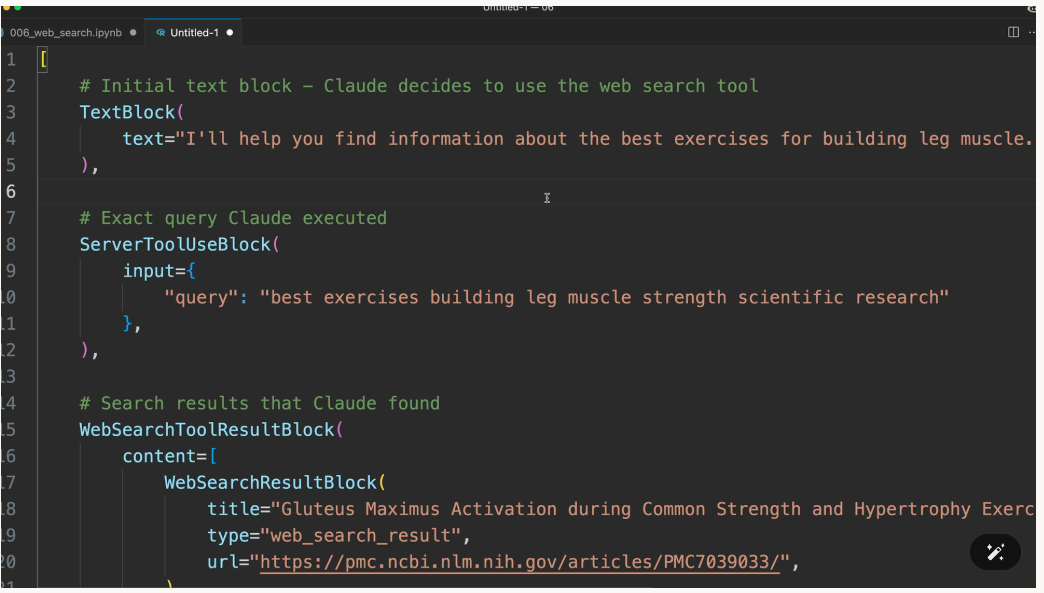

## Restricting Search Domains

In [4]:
web_search_schema = {
    "type": "web_search_20250305",
    "name": "web_search",
    "max_uses": 5,
    "allowed_domains": ["nih.gov"]
}

## Practical Usage
The web search tool works best for:

* Current events and recent developments
* Specialized information not in Claude's training data
* Fact-checking and finding authoritative sources
* Research tasks requiring up-to-date information

Simply include the schema in your tools array when making API calls, and Claude will automatically decide when a web search would help answer the user's question.